In [1]:
pip install psycopg2-binary

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
import pandas.io.sql as sqlio
import psycopg2 as ps

In [3]:
conn = ps.connect(dbname="Proje/NorthWind",
                  user="postgres",
                  password="12345",
                  port = "5432")

# Müşterilerin Ülkeleri ve Sipariş Sayılarına Bakalım;

In [4]:
sql= """SELECT c.country,
COUNT(o.order_id) AS order_count
FROM customers AS c
JOIN orders AS o ON c.customer_id = o.customer_id
GROUP BY 1
ORDER BY 2 DESC"""

In [5]:
df = sqlio.read_sql_query(sql,conn)
df

C:\Users\HP\AppData\Local\Temp\ipykernel_11680\3836415318.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = sqlio.read_sql_query(sql,conn)


,country,order_count
0,Germany,122
1,USA,122
2,Brazil,83
3,France,77
4,UK,56
5,Venezuela,46
6,Austria,40
7,Sweden,37
8,Canada,30
9,Italy,28


In [6]:
df.shape

(21, 2)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21 entries, 0 to 20
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   country      21 non-null     object
 1   order_count  21 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 468.0+ bytes


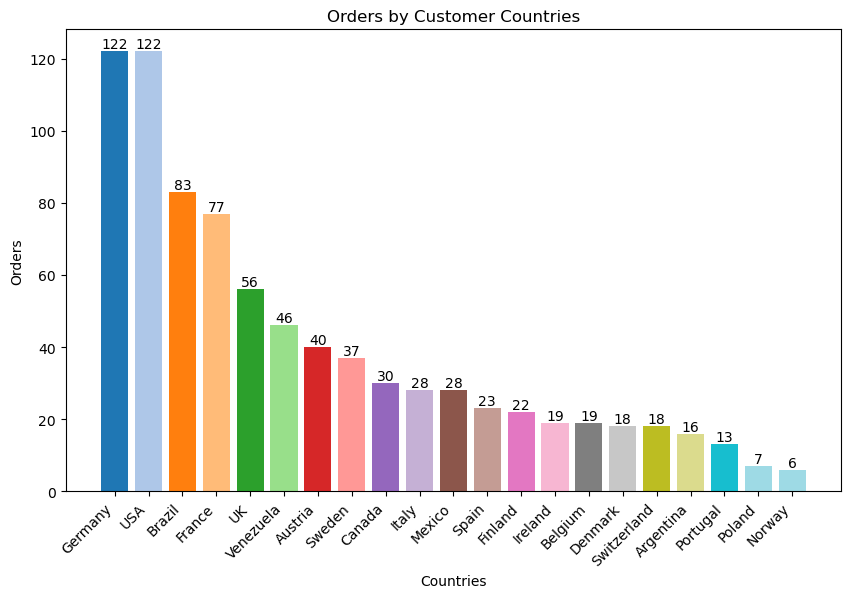

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Rastgele renkler oluşturarak barplot oluşturuyorum;
colors = plt.cm.tab20(np.linspace(0, 1, len(df)))

plt.figure(figsize=(10, 6))
bars = plt.bar(df["country"], df["order_count"], color=colors)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), va='bottom', ha='center')


plt.title('Orders by Customer Countries')
plt.xlabel('Countries')
plt.ylabel('Orders')
plt.xticks(rotation=45, ha="right")


plt.show()


# Kargo Şirketlerinin Performansına Bakalım;

In [9]:
sql = """SELECT s.shipper_id, s.company_name,
COUNT(DISTINCT o.order_id) AS total_orders,
ROUND(AVG(o.freight)::numeric,2) AS avg_freight,
ROUND(AVG(EXTRACT(DAY FROM (o.shipped_date - o.order_date) * interval '1 DAY'))::numeric,0) AS avg_shipping_days
FROM shippers AS s
JOIN orders AS o ON s.shipper_id = o.ship_via
GROUP BY 1,2"""

In [10]:
df = sqlio.read_sql_query(sql,conn)
df

C:\Users\HP\AppData\Local\Temp\ipykernel_11680\3836415318.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = sqlio.read_sql_query(sql,conn)


,shipper_id,company_name,total_orders,avg_freight,avg_shipping_days
0,1,Speedy Express,249,65.00,9.0
1,2,United Package,326,86.64,9.0
2,3,Federal Shipping,255,80.44,7.0


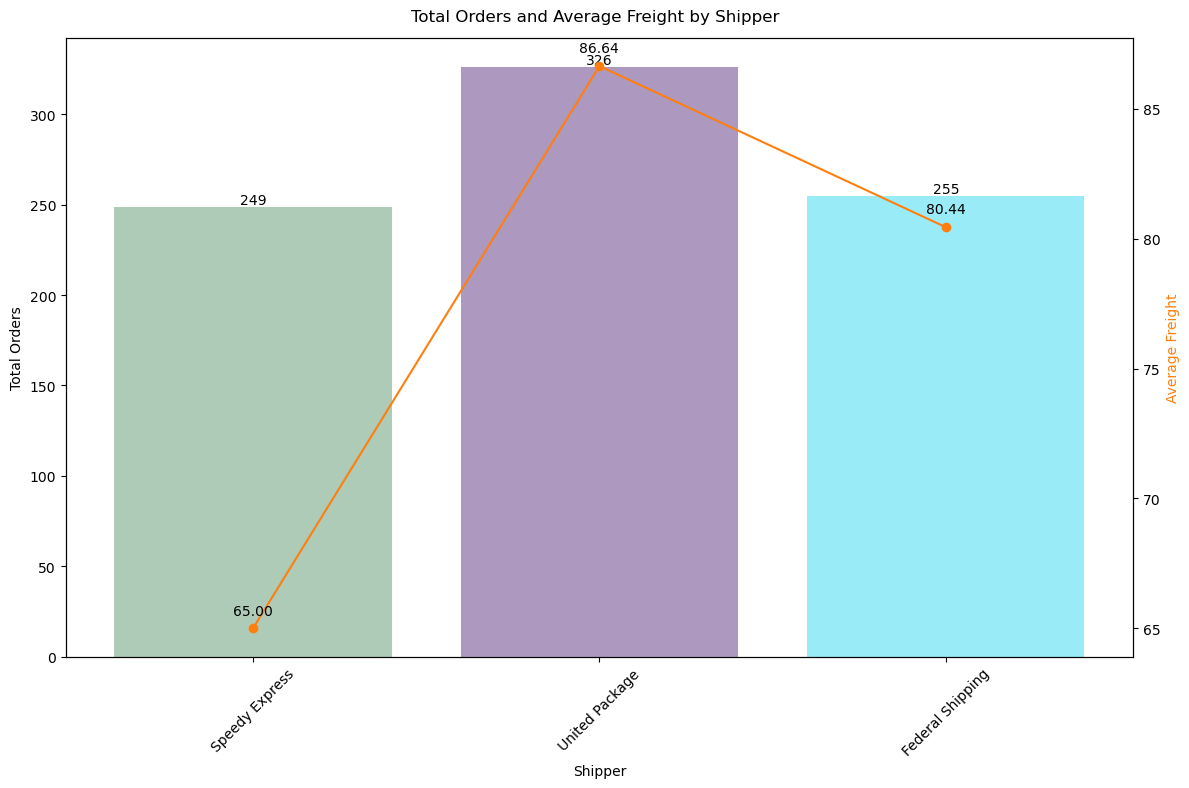

In [11]:
# Rastgele renkler oluşturarak bar grafiği yapalım;
np.random.seed(0)
colors = np.random.rand(len(df), 3) 

fig, ax1 = plt.subplots(figsize=(12, 8))

bars = ax1.bar(df['company_name'], df['total_orders'], color=colors, alpha=0.7, label='Total Orders')
ax1.set_xlabel('Shipper')
ax1.set_ylabel('Total Orders')

for bar in bars:
    yval = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2, yval, int(yval), va='bottom', ha='center')

ax2 = ax1.twinx()
color = 'tab:orange'
line = ax2.plot(df['company_name'], df['avg_freight'], color=color, marker='o', label='Average Freight')
ax2.set_ylabel('Average Freight', color=color)

for i, txt in enumerate(df['avg_freight']):
    ax2.annotate(f'{txt:.2f}', (df['company_name'][i], df['avg_freight'][i]), textcoords="offset points", xytext=(0,10), ha='center')

fig.suptitle('Total Orders and Average Freight by Shipper')
ax1.tick_params(axis='x', rotation=45)

fig.tight_layout()
plt.show()

# Aylık Toplam Brüt Gelire Bakalım;

In [12]:
sql = """SELECT 
EXTRACT(MONTH FROM order_date) AS month_number, 
TO_CHAR(order_date, 'Month') AS month_name,
COUNT(o.order_id) AS total_orders,
ROUND(SUM(od.quantity * od.unit_price)::numeric, 2) AS total_price
FROM orders AS o
JOIN order_details AS od ON od.order_id = o.order_id
GROUP BY 1, 2
ORDER BY 1"""

In [13]:
df = sqlio.read_sql_query(sql,conn)
df

C:\Users\HP\AppData\Local\Temp\ipykernel_11680\3836415318.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = sqlio.read_sql_query(sql,conn)


,month_number,month_name,total_orders,total_price
0,1.0,January,237,167547.52
1,2.0,February,201,145769.15
2,3.0,March,255,149805.35
3,4.0,April,261,190329.95
4,5.0,May,155,76722.36
5,6.0,June,76,39088.00
6,7.0,July,136,85657.03
7,8.0,August,153,76591.09
8,9.0,September,152,87369.02
9,10.0,October,179,111532.10


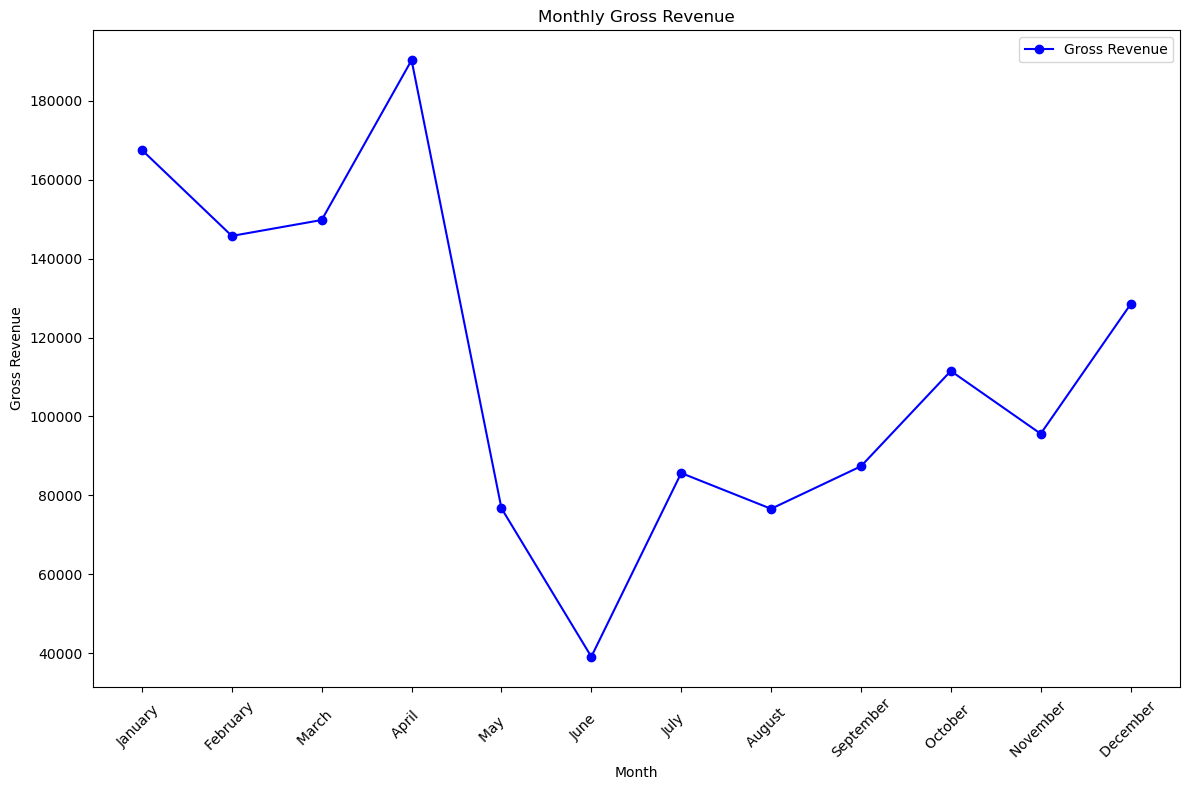

In [14]:
plt.figure(figsize=(12, 8))


plt.plot(df['month_number'], df['total_price'], marker='o', color='b', label='Gross Revenue')


plt.xticks(df['month_number'], df['month_name'], rotation=45)


plt.title('Monthly Gross Revenue')
plt.xlabel('Month')
plt.ylabel('Gross Revenue')
plt.legend()


plt.tight_layout()
plt.show()


# Her Kategoride En Çok Satan Ürünlere Bakalım;

In [15]:
sql = """WITH top_selling_category AS(
SELECT c.category_id, c.category_name, product_name,
SUM(od.quantity) AS top_product,
RANK() OVER (PARTITION BY c.category_name ORDER BY sum(od.quantity) DESC) AS RANK
FROM categories AS c
JOIN products AS p ON p.category_id=c.category_id
JOIN order_details AS od ON od.product_id=p.product_id
GROUP BY 1,2,3)
SELECT * FROM top_selling_category WHERE rank=1
ORDER BY top_product DESC"""

In [16]:
df = sqlio.read_sql_query(sql,conn)
df

C:\Users\HP\AppData\Local\Temp\ipykernel_11680\3836415318.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = sqlio.read_sql_query(sql,conn)


,category_id,category_name,product_name,top_product,rank
0,4,Dairy Products,Camembert Pierrot,1577,1
1,5,Grains/Cereals,Gnocchi di nonna Alice,1263,1
2,3,Confections,Pavlova,1158,1
3,1,Beverages,Rhönbräu Klosterbier,1155,1
4,8,Seafood,Boston Crab Meat,1103,1
5,6,Meat/Poultry,Alice Mutton,978,1
6,7,Produce,Manjimup Dried Apples,886,1
7,2,Condiments,Original Frankfurter grüne Soße,791,1


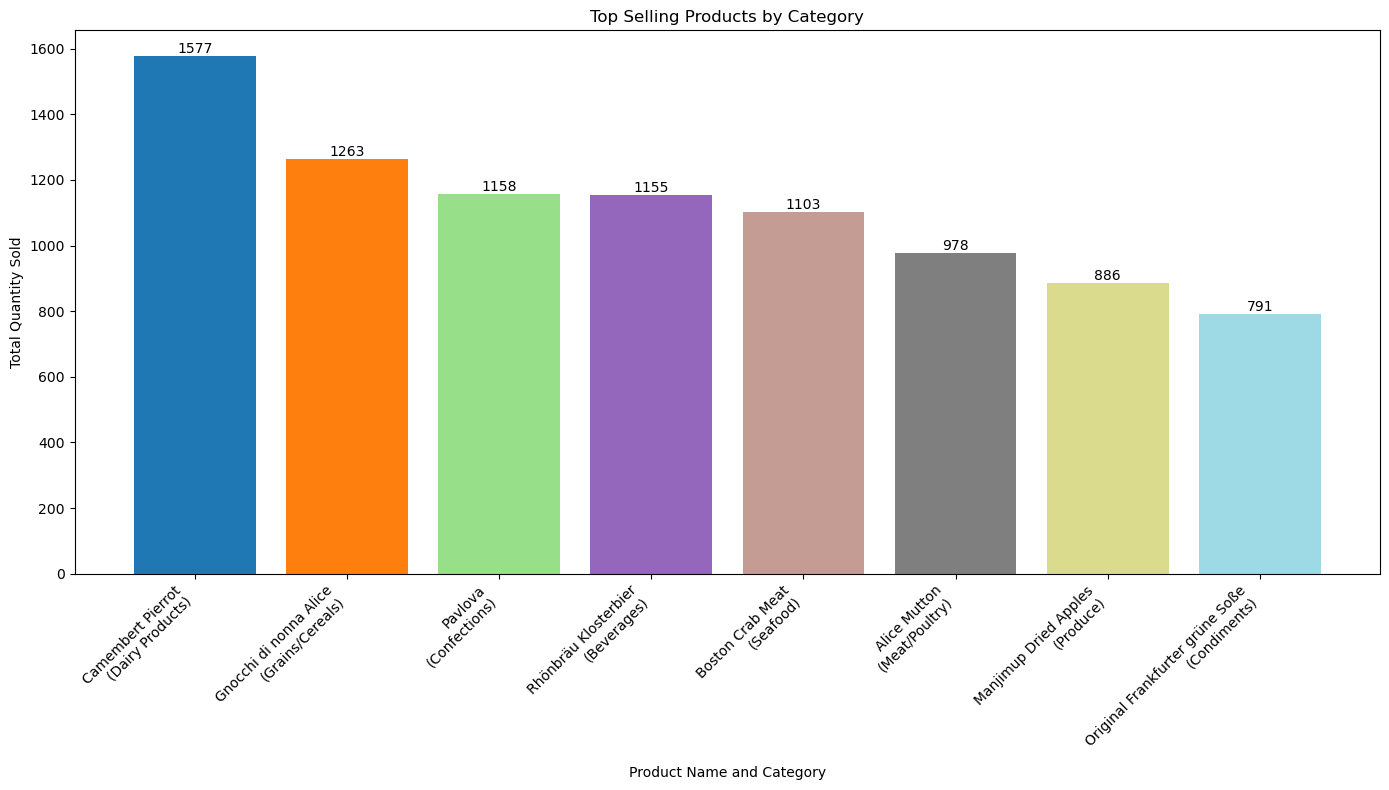

In [17]:
# Renkler için bir renk paleti oluşturalım;
colors = plt.cm.tab20(np.linspace(0, 1, len(df)))

plt.figure(figsize=(14, 8))

bars = plt.bar(df['product_name'], df['top_product'], color=colors)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), va='bottom', ha='center')

plt.title('Top Selling Products by Category')
plt.xlabel('Product Name and Category')
plt.ylabel('Total Quantity Sold')

x_labels = [f'{row["product_name"]}\n({row["category_name"]})' for index, row in df.iterrows()]
plt.xticks(ticks=np.arange(len(df)), labels=x_labels, rotation=45, ha='right')

plt.tight_layout()
plt.show()